# Model Checker Solver Performance Comparison

This notebook analyzes the performance of different model checking solvers by comparing their execution times across the same benchmark cases. It will generate visualization plots for:

1. Scatter plots comparing solver performance (log-log scale)
2. Speedup comparison between solvers
3. Performance profile showing the distribution of solving efficiency

**Note:** Only cases where all solvers have valid results will be included in the analysis.

In [54]:
# Import required libraries
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

# Set base directory
BENCHMARK_DIR = "/Users/huguangyu/coding_env/MC-aig-only-benchmark"
ABC_DIR = os.path.join(BENCHMARK_DIR, "abc_solver_logs")
RIC3_BASELINE_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_baseline_logs")
RIC3_DYNAMIC_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_dynamic_logs")
RIC3_ADAPTIVE_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_adaptive_logs")

## Functions for Extracting Solver Data

The following functions extract solving times from log files for different solvers.

In [55]:
def extract_time_from_abc_log(log_path):
    """Extract solving time from ABC solver log file"""
    try:
        with open(log_path, 'r') as f:
            content = f.read()
            # Check if timeout
            if "STATUS: TIMEOUT" in content:
                return 3600  # Return timeout value (3600 seconds)
            
            # Try to find the completion time
            time_match = re.search(r'(\d+\.\d+) sec', content)
            if time_match:
                return float(time_match.group(1))
            
            # If no time found but completed
            if "STATUS: COMPLETED" in content:
                # Look for the last time entry in the frame data
                time_entries = re.findall(r'\s+(\d+\.\d+) sec', content)
                if time_entries:
                    return float(time_entries[-1])
        
        return None  # Could not parse time
    except Exception as e:
        print(f"Error parsing {log_path}: {e}")
        return None

def extract_time_from_ric3_log(log_path):
    """Extract solving time from rIC3 solver log file"""
    try:
        with open(log_path, 'r') as f:
            content = f.read()
            
            # Check if timeout
            if "STATUS: TIMEOUT" in content:
                return 3600  # Return timeout value
            
            # Extract time from statistics
            time_match = re.search(r'time: (\d+\.\d+)s', content)
            if time_match:
                return float(time_match.group(1))
        
        return None  # Could not parse time
    except Exception as e:
        print(f"Error parsing {log_path}: {e}")
        return None

## Finding Common Cases Across All Solvers

We only want to include cases where all solvers have log files available.

In [56]:
def find_common_cases(abc_dir, ric3_baseline_dir, ric3_dynamic_dir, ric3_adaptive_dir):
    """Find cases that exist in all three log directories"""
    abc_logs = {os.path.basename(f) for f in glob.glob(os.path.join(abc_dir, "*.txt"))}
    ric3_baseline_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_baseline_dir, "*.txt"))}
    ric3_dynamic_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_dynamic_dir, "*.txt"))}
    ric3_adaptive_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_adaptive_dir, "*.txt"))}
    
    # Find common log files across all three directories
    common_logs = abc_logs.intersection(ric3_baseline_logs, ric3_dynamic_logs, ric3_adaptive_logs)
    return common_logs

# Find common cases
common_cases = find_common_cases(ABC_DIR, RIC3_BASELINE_DIR, RIC3_DYNAMIC_DIR, RIC3_ADAPTIVE_DIR)
print(f"Found {len(common_cases)} common cases across all solvers")

Found 624 common cases across all solvers


## Extracting Solving Times

Now we'll extract the solving times for each case and store them in a DataFrame.

In [57]:
# Create a DataFrame to store the results
results_data = []

# Process each case and extract times
for case in common_cases:
    abc_time = extract_time_from_abc_log(os.path.join(ABC_DIR, case))
    ric3_baseline_time = extract_time_from_ric3_log(os.path.join(RIC3_BASELINE_DIR, case))
    ric3_dynamic_time = extract_time_from_ric3_log(os.path.join(RIC3_DYNAMIC_DIR, case))
    ric3_adaptive_time = extract_time_from_ric3_log(os.path.join(RIC3_ADAPTIVE_DIR, case))
    
    # Only include case if all solvers have valid results
    if abc_time is not None and ric3_baseline_time is not None and ric3_dynamic_time is not None and ric3_adaptive_time is not None:
        results_data.append({
            "case": case.replace("_log.txt", ""),
            "abc": abc_time,
            "ric3_baseline": ric3_baseline_time,
            "ric3_dynamic": ric3_dynamic_time,
            "ric3_adaptive": ric3_adaptive_time
        })

# Create DataFrame
results_df = pd.DataFrame(results_data)
print(f"Successfully parsed {len(results_df)} cases with valid times from all solvers")

# Display the first few rows
results_df.head()

Successfully parsed 576 cases with valid times from all solvers


,case,abc,ric3_baseline,ric3_dynamic,ric3_adaptive
0,cal201,3600.00,3600.00,3600.00,3600.00
1,6s403rb1342,0.04,0.50,0.64,1.21
2,gen43,0.60,0.27,0.27,0.36
3,arbitrated_top_n3_w8_d128_e0,3600.00,3600.00,3600.00,3600.00
4,collision.6.prop1-func-interl,0.03,2.44,2.92,3.54


## Add Derived Metrics

Add speedup ratios and other derived metrics for analysis.

In [58]:
# Add speedup ratios (ABC time / solver time)
# Greater than 1 means the solver is faster than ABC
results_df["baseline_speedup"] = results_df["abc"] / results_df["ric3_baseline"]
results_df["dynamic_speedup"] = results_df["abc"] / results_df["ric3_dynamic"]

# Add timeout indicators
results_df["abc_timeout"] = results_df["abc"] >= 3600
results_df["baseline_timeout"] = results_df["ric3_baseline"] >= 3600
results_df["dynamic_timeout"] = results_df["ric3_dynamic"] >= 3600

# Summary statistics
print("Summary of solving times:")
print(results_df[["abc", "ric3_baseline", "ric3_dynamic"]].describe())

print("\nTimeout counts:")
print(f"ABC: {results_df['abc_timeout'].sum()} timeouts")
print(f"rIC3 Baseline: {results_df['baseline_timeout'].sum()} timeouts")
print(f"rIC3 Dynamic: {results_df['dynamic_timeout'].sum()} timeouts")

Summary of solving times:
               abc  ric3_baseline  ric3_dynamic
count   576.000000     576.000000    576.000000
mean    962.626545     745.232743    631.669201
std    1594.605109    1399.492458   1273.556734
min       0.000000       0.000000      0.000000
25%       0.000000       0.130000      0.130000
50%       0.020000       3.885000      3.920000
75%    3600.000000     267.037500    227.472500
max    3600.000000    3600.000000   3600.000000

Timeout counts:
ABC: 154 timeouts
rIC3 Baseline: 106 timeouts
rIC3 Dynamic: 83 timeouts


## Scatter Plot Comparisons

Create scatter plots to compare the performance of different solvers.

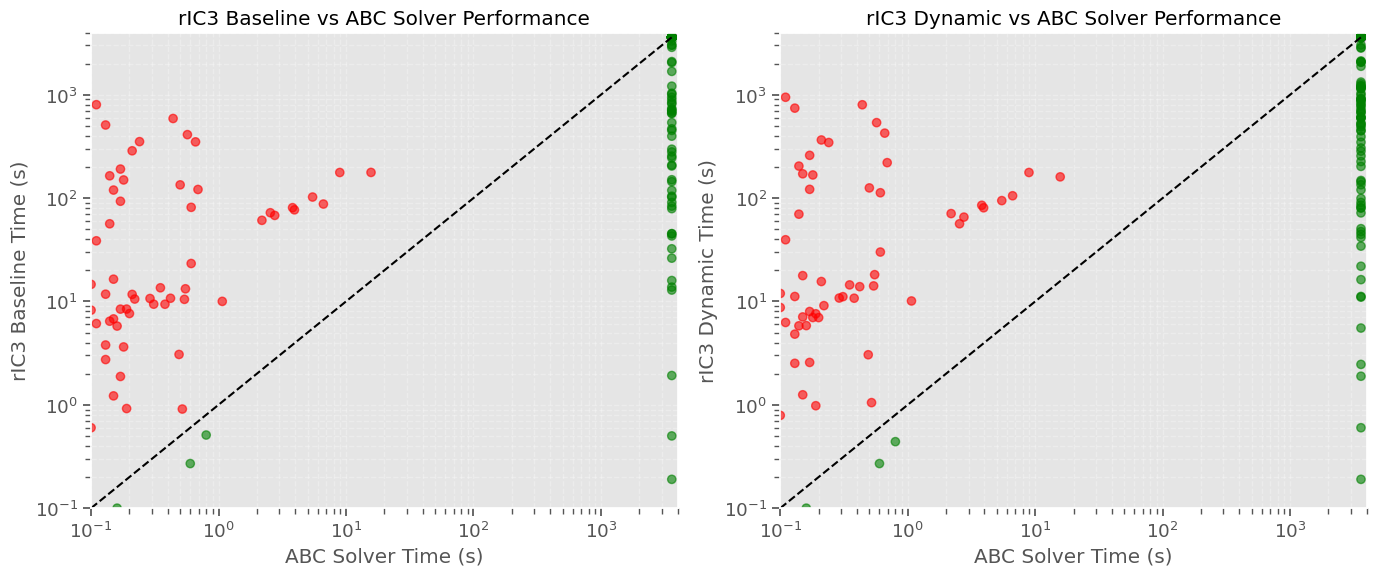

In [59]:
plt.figure(figsize=(14, 6))

# Plot 1: rIC3 Baseline vs ABC
plt.subplot(1, 2, 1)
plt.scatter(
    results_df["abc"], 
    results_df["ric3_baseline"], 
    alpha=0.6, 
    c=results_df["baseline_speedup"].apply(lambda x: 'red' if x < 1 else 'green')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ABC Solver Time (s)')
plt.ylabel('rIC3 Baseline Time (s)')
plt.title('rIC3 Baseline vs ABC Solver Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

# Plot 2: rIC3 Dynamic vs ABC
plt.subplot(1, 2, 2)
plt.scatter(
    results_df["abc"], 
    results_df["ric3_dynamic"], 
    alpha=0.6, 
    c=results_df["dynamic_speedup"].apply(lambda x: 'red' if x < 1 else 'green')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ABC Solver Time (s)')
plt.ylabel('rIC3 Dynamic Time (s)')
plt.title('rIC3 Dynamic vs ABC Solver Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('solver_comparison.png', dpi=300)
plt.show()

## Speedup Comparison

Create a plot showing the speedup ratios sorted from lowest to highest.

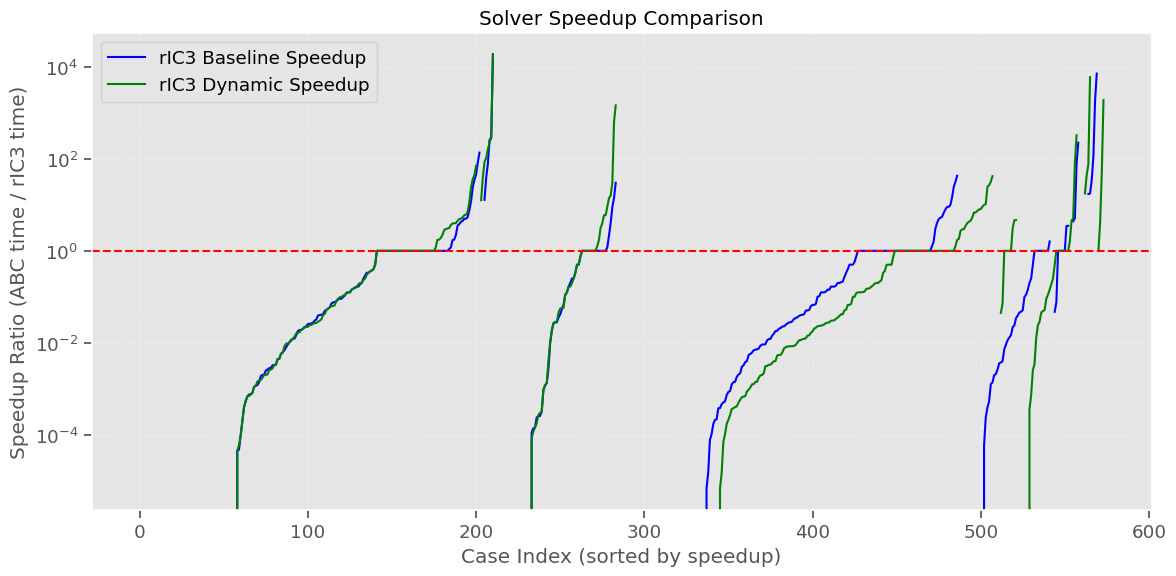

Speedup summary statistics:
       baseline_speedup  dynamic_speedup
count        565.000000       565.000000
mean                inf              inf
std                 NaN              NaN
min            0.000000         0.000000
25%            0.000047         0.000059
50%            0.040000         0.035349
75%            1.000000         1.000000
max                 inf              inf

rIC3 Baseline faster than ABC: 75 cases (13.0%)
rIC3 Dynamic faster than ABC: 98 cases (17.0%)


/Users/huguangyu/miniconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/huguangyu/miniconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [60]:
plt.figure(figsize=(12, 6))

# Sort the speedup values for better visualization
baseline_speedup = sorted(results_df["baseline_speedup"].values)
dynamic_speedup = sorted(results_df["dynamic_speedup"].values)

# Plot sorted speedups
plt.plot(range(len(baseline_speedup)), baseline_speedup, 'b-', label='rIC3 Baseline Speedup')
plt.plot(range(len(dynamic_speedup)), dynamic_speedup, 'g-', label='rIC3 Dynamic Speedup')

plt.axhline(y=1, color='r', linestyle='--')  # Line at y=1 (no speedup)
plt.yscale('log')
plt.xlabel('Case Index (sorted by speedup)')
plt.ylabel('Speedup Ratio (ABC time / rIC3 time)')
plt.title('Solver Speedup Comparison')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('solver_speedup.png', dpi=300)
plt.show()

# Print summary statistics for speedups
print("Speedup summary statistics:")
print(results_df[["baseline_speedup", "dynamic_speedup"]].describe())

# Count cases where each solver is faster
baseline_faster = sum(results_df["baseline_speedup"] > 1)
dynamic_faster = sum(results_df["dynamic_speedup"] > 1)
total_cases = len(results_df)

print(f"\nrIC3 Baseline faster than ABC: {baseline_faster} cases ({baseline_faster/total_cases:.1%})")
print(f"rIC3 Dynamic faster than ABC: {dynamic_faster} cases ({dynamic_faster/total_cases:.1%})")

## Performance Profile

A performance profile shows the fraction of problems solved within a certain factor of the best solver's time.

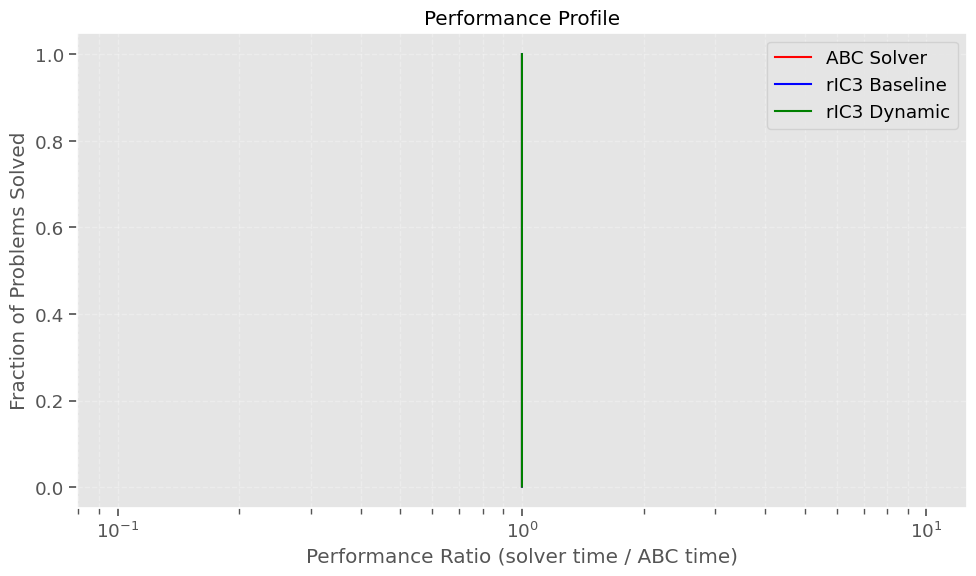

In [61]:
def performance_profile(times, baseline_times):
    """Generate performance profile data points"""
    try:
        ratios = [t / baseline_times[i] for i, t in enumerate(times)]
    except ZeroDivisionError:
        ratios = [1] * len(times)
    ratios.sort()
    y = np.arange(1, len(ratios) + 1) / len(ratios)
    return ratios, y

# Extract times as lists
abc_times = results_df["abc"].tolist()
baseline_times = results_df["ric3_baseline"].tolist()
dynamic_times = results_df["ric3_dynamic"].tolist()

# Use ABC times as baseline for ratio calculation
abc_ratios, abc_y = performance_profile(abc_times, abc_times)  # Will always be 1
baseline_ratios, baseline_y = performance_profile(baseline_times, abc_times)
dynamic_ratios, dynamic_y = performance_profile(dynamic_times, abc_times)

plt.figure(figsize=(10, 6))
plt.step(abc_ratios, abc_y, 'r-', label='ABC Solver', where='post')
plt.step(baseline_ratios, baseline_y, 'b-', label='rIC3 Baseline', where='post')
plt.step(dynamic_ratios, dynamic_y, 'g-', label='rIC3 Dynamic', where='post')

plt.xscale('log')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlabel('Performance Ratio (solver time / ABC time)')
plt.ylabel('Fraction of Problems Solved')
plt.title('Performance Profile')
plt.legend()

plt.tight_layout()
plt.savefig('performance_profile.png', dpi=300)
plt.show()

## Additional Analysis: Direct Comparison of rIC3 Implementations

Compare the dynamic and baseline implementations of rIC3 to each other.

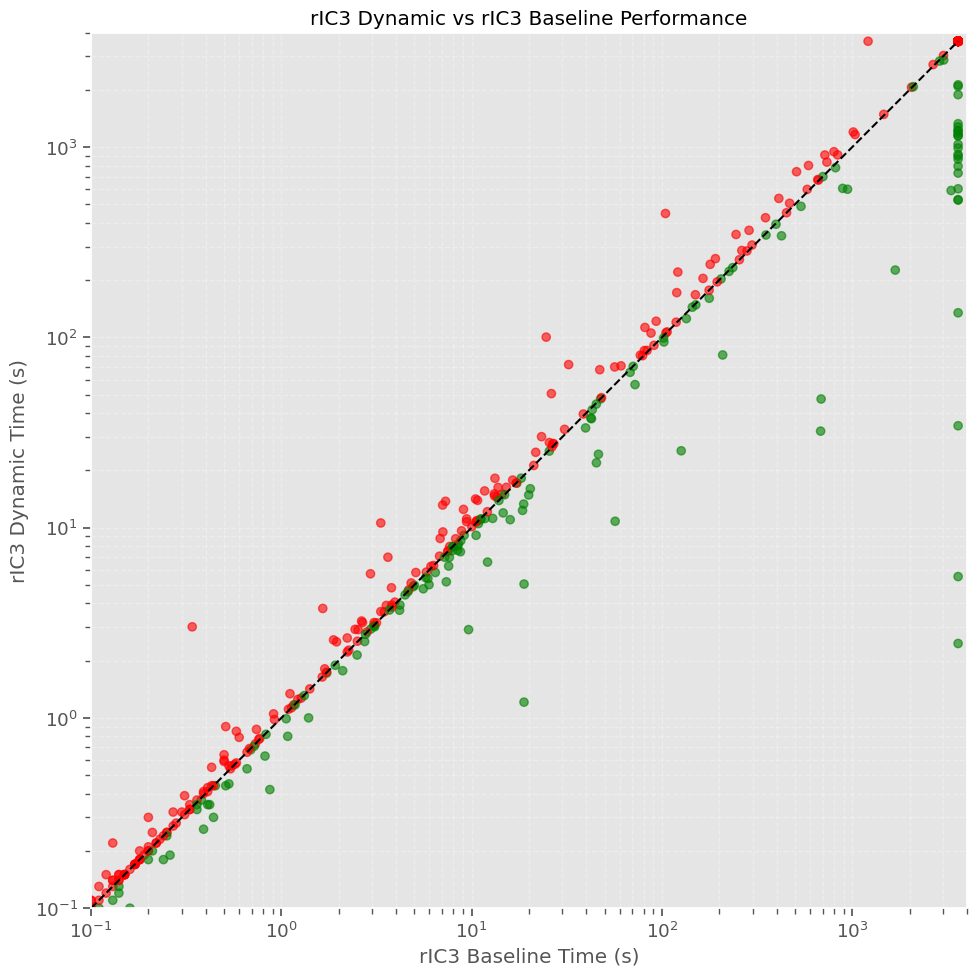

rIC3 Dynamic faster than rIC3 Baseline: 156 cases (27.1%)
Dynamic vs Baseline ratio statistics:
count    552.000000
mean            inf
std             NaN
min        0.000000
25%        0.982103
50%        1.000000
75%        1.007214
max             inf
Name: dynamic_vs_baseline_ratio, dtype: float64


/Users/huguangyu/miniconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [62]:
plt.figure(figsize=(10, 10))

# Create dynamic vs baseline ratio
results_df["dynamic_vs_baseline_ratio"] = results_df["ric3_baseline"] / results_df["ric3_dynamic"]
dynamic_faster_count = sum(results_df["dynamic_vs_baseline_ratio"] > 1)

plt.scatter(
    results_df["ric3_baseline"], 
    results_df["ric3_dynamic"], 
    alpha=0.6, 
    c=results_df["dynamic_vs_baseline_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Baseline Time (s)')
plt.ylabel('rIC3 Dynamic Time (s)')
plt.title('rIC3 Dynamic vs rIC3 Baseline Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
plt.show()

print(f"rIC3 Dynamic faster than rIC3 Baseline: {dynamic_faster_count} cases ({dynamic_faster_count/total_cases:.1%})")
print("Dynamic vs Baseline ratio statistics:")
print(results_df["dynamic_vs_baseline_ratio"].describe())

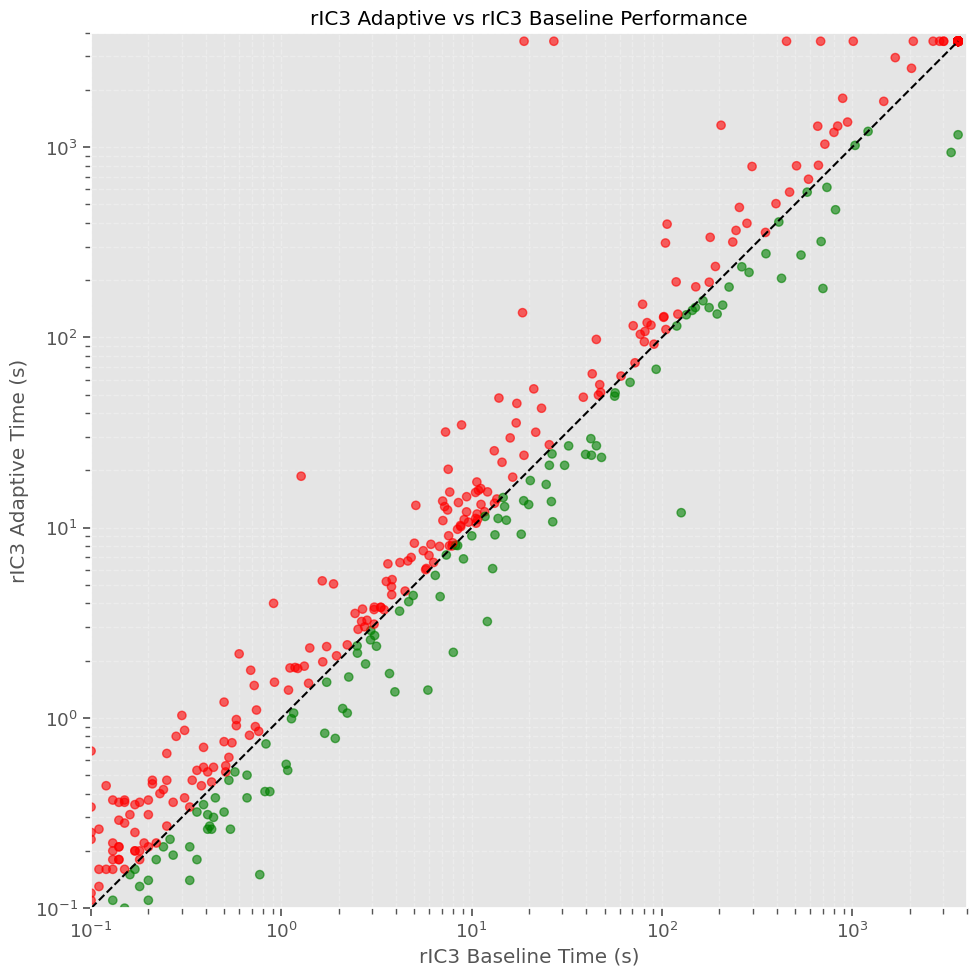

rIC3 Adaptive faster than rIC3 Baseline: 117 cases (20.3%)
Adaptive vs Baseline ratio statistics:
count    573.000000
mean       0.869581
std        0.692836
min        0.000000
25%        0.500000
50%        0.850877
75%        1.000000
max       10.537563
Name: adaptive_vs_baseline_ratio, dtype: float64


In [63]:
plt.figure(figsize=(10, 10))

# Create adaptive vs baseline ratio
results_df["adaptive_vs_baseline_ratio"] = results_df["ric3_baseline"] / results_df["ric3_adaptive"]
adaptive_faster_count = sum(results_df["adaptive_vs_baseline_ratio"] > 1)

plt.scatter(
    results_df["ric3_baseline"], 
    results_df["ric3_adaptive"], 
    alpha=0.6, 
    c=results_df["adaptive_vs_baseline_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Baseline Time (s)')
plt.ylabel('rIC3 Adaptive Time (s)')
plt.title('rIC3 Adaptive vs rIC3 Baseline Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
plt.show()

print(f"rIC3 Adaptive faster than rIC3 Baseline: {adaptive_faster_count} cases ({adaptive_faster_count/total_cases:.1%})")
print("Adaptive vs Baseline ratio statistics:")
print(results_df["adaptive_vs_baseline_ratio"].describe())

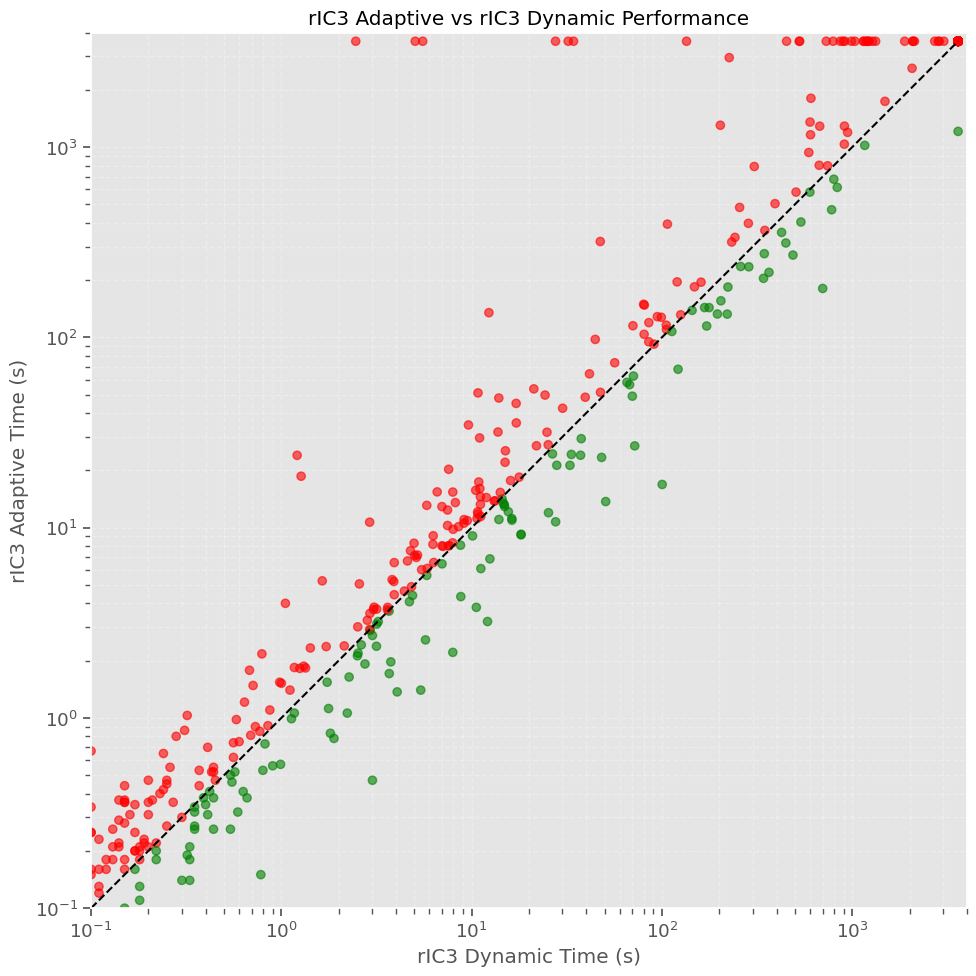

rIC3 Adaptive faster than rIC3 Dynamic: 121 cases (21.0%)
Adaptive vs Dynamic ratio statistics:
count    573.000000
mean       0.848916
std        0.666621
min        0.000000
25%        0.473684
50%        0.823086
75%        1.000000
max        6.404255
Name: adaptive_vs_dynamic_ratio, dtype: float64


In [67]:
plt.figure(figsize=(10, 10))

# Create adaptive vs dynamic ratio
results_df["adaptive_vs_dynamic_ratio"] = results_df["ric3_dynamic"] / results_df["ric3_adaptive"]
adaptive_faster_count = sum(results_df["adaptive_vs_dynamic_ratio"] > 1)

plt.scatter(
    results_df["ric3_dynamic"], 
    results_df["ric3_adaptive"], 
    alpha=0.6, 
    c=results_df["adaptive_vs_dynamic_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Dynamic Time (s)')
plt.ylabel('rIC3 Adaptive Time (s)')
plt.title('rIC3 Adaptive vs rIC3 Dynamic Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
plt.show()

print(f"rIC3 Adaptive faster than rIC3 Dynamic: {adaptive_faster_count} cases ({adaptive_faster_count/total_cases:.1%})")
print("Adaptive vs Dynamic ratio statistics:")
print(results_df["adaptive_vs_dynamic_ratio"].describe())

## Save Results to CSV

Store the processed results for later reference.

In [65]:
# Save results to CSV
results_df.to_csv('solver_comparison_results.csv', index=False)
print("Results saved to 'solver_comparison_results.csv'")

Results saved to 'solver_comparison_results.csv'
